<a href="https://colab.research.google.com/github/outalbamine/M_DLearning/blob/main/mailinback_phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
import spacy  # For preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import re  # For preprocessing
import urllib
from collections import Counter
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
raw_data = pd.read_csv("dataset.csv", sep=',', encoding='latin1')
raw_data.head()

,domain,label;;;;;
0,http://sprint.com/business/solutions/mobility_...,0;;;;;
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.0;;;;;
2,http://web.de/magazine/digital/sicher-im-netz/...,0;;;;;
3,www.wired.com/science/discoveries/news/1999/08...,0.0;;;;;
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1.0;;;;;


Nettoyage des données :
 -Nous débutons par éliminer les points-virgules dans la deuxième colonne.
 -Suppression des lignes en double si elles sont présentes.
 -Extraction du nom de domaine à l'aide du module urllib.
 -J'ai envisagé l'utilisation du module whose pour extraire des informations sur l'URL, telles que la date de création, mais étant donné que les données peuvent être anciennes, cela risque de fausser le modèle.


In [4]:
raw_data = raw_data.rename(columns={'label;;;;;': 'label' })
raw_data['label'] = raw_data['label'].apply(lambda x: int(float(x[0])))
raw_data['domain_tran'] = raw_data['domain'].apply(lambda x: urllib.parse.unquote(x, encoding='utf-8', errors='replace'))
raw_data.drop_duplicates(inplace=True)
data=raw_data.copy()

Observer la répartition des étiquettes afin d'avoir une idée sur la distribution de la valeur cible.

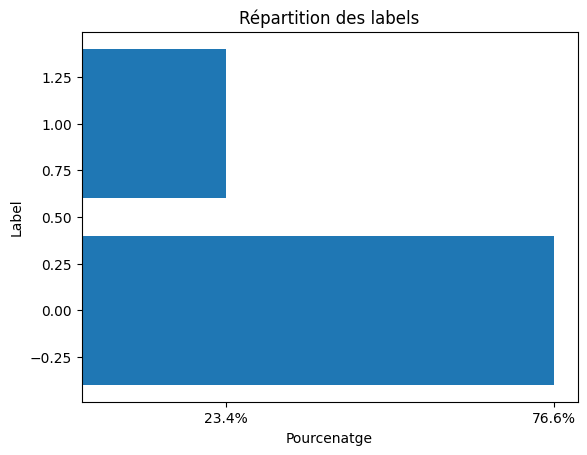

In [ ]:
counts = data['label'].value_counts(normalize=True)

# Créer un graphique à barres horizontales
plt.barh(counts.index, counts.values)

# Ajouter les pourcentages sur l'axe des x
plt.xticks(ticks=[i for i in counts.values], labels=[f'{round(i*100,2)}%' for i in counts.values])

# Ajouter un titre et des labels pour les axes
plt.title('Répartition des labels')
plt.xlabel('Pourcenatge')
plt.ylabel('Label')

# Afficher le graphique
plt.show()

Il est important de souligner que "ligitime" est prédominante, représentant 76.6% des données. Par conséquent, je vais procéder à une méthode de suréchantillonnage pour équilibrer les deux classes.

In [5]:

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def lemm(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop and len(token) > 2]
    return ' '.join(txt)

Le processus de nettoyage des URL diffère quelque peu du nettoyage de texte classique. Bien qu'il suive les étapes similaires du nettoyage de texte, il nécessite une attention particulière à certains points spécifiques :

Suppression des parties inutiles : Il est essentiel d'éliminer les parties de l'URL qui n'apportent pas d'informations pertinentes pour votre analyse.

Suppression des symboles de ponctuation : Les symboles de ponctuation inutiles peuvent être éliminés pour simplifier l'URL et la rendre plus facile à traiter.

Conservation des informations de protocole : Contrairement au nettoyage de texte où l'on peut supprimer des préfixes comme http ou https, il peut être nécessaire de conserver ces informations dans les URL pour maintenir leur intégrité et leur structure.

In [6]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data['domain'])
txt = [lemm(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
df_clean = pd.DataFrame({'transformed_text': txt})
data['transformed_text'] = df_clean['transformed_text']
data.head()

,domain,label,domain_tran,transformed_text
0,http://sprint.com/business/solutions/mobility_...,0,http://sprint.com/business/solutions/mobility_...,http sprint com business solution mobility sec...
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0,hesperia.gsfc.nasa.gov/~schmahl/nnls/,hesperia gsfc nasa gov schmahl nnls
2,http://web.de/magazine/digital/sicher-im-netz/...,0,http://web.de/magazine/digital/sicher-im-netz/...,http web magazine digital sicher netz sicherhe...
3,www.wired.com/science/discoveries/news/1999/08...,0,www.wired.com/science/discoveries/news/1999/08...,www wire com science discovery news
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,thomas arnatt com include pono aol logio htm


La fonction lemm prend un texte en entrée, qui est ensuite traité par le pipeline de traitement de spaCy pour convertir chaque token en sa forme canonique (lemmatization) et vérifier si ce token n'est pas un mot vide (stopword). Enfin, les tokens filtrés sont concaténés en une chaîne de texte nettoyée et normalisée qui est renvoyée en sortie.

In [7]:
data = data[['label', 'transformed_text']]
data.head()

,label,transformed_text
0,0,http sprint com business solution mobility sec...
1,0,hesperia gsfc nasa gov schmahl nnls
2,0,http web magazine digital sicher netz sicherhe...
3,0,www wire com science discovery news
4,1,thomas arnatt com include pono aol logio htm


Pour la phase de vectorisation, j ai choisi la méthode TF-IDF (Term Frequency-Inverse Document Frequency) pour les raisons suivantes :

La rareté des mots clés : TF-IDF est bien adapté pour traiter cette rareté en attribuant des pondérations plus élevées à ces termes, ce qui permet de mieux les distinguer dans la représentation vectorielle.

Les URL peuvent contenir des éléments de texte redondants ou peu informatifs tels que les identifiants de session ou les paramètres de suivi. En utilisant TF-IDF, ces éléments communs seront pondérés moins fortement, réduisant ainsi leur impact sur la représentation finale.

La simplicité de mise en œuvre et la faible charge computationnelle sont des avantages supplémentaires de cette méthode.





In [ ]:
text_list = data['transformed_text'].astype(str).tolist()

# Concatenate all the texts into a single string
all_text = ' '.join(text_list)

# Tokenize the text
tokens = nltk.word_tokenize(all_text)

# Convert all the tokens to lowercase
tokens = [token.lower() for token in tokens]

# Count the frequency of each word
freq_dist = Counter(tokens)

# Sort the words by frequency in descending order
sorted_words = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 words with their frequency counts
for word, frequency in sorted_words[:10]:
    print(word, frequency)

com 70837
http 35072
www 32427
html 24346
net 13880
org 10558
php 8324
htm 8251
index 6958
login 6714


Il est observé que le nombre de mots présents est considérable. Pour mieux visualiser cela, je vais tracer la fréquence minimale des mots ainsi que la taille du tuple sorted_words

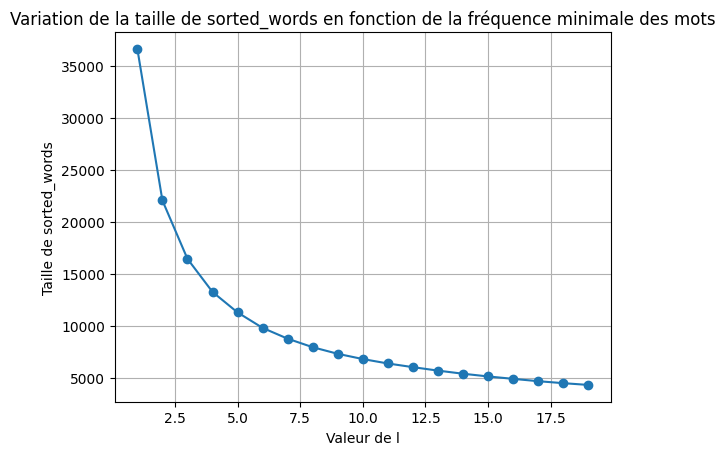

In [ ]:
tailles_sorted_words = []

# Parcourez une plage de valeurs de l
for l in range(1, 20):  # Changez 11 à la valeur maximale de l que vous souhaitez tester + 1
    # Filtrer sorted_words pour inclure uniquement les mots avec une fréquence supérieure à l
    sorted_words_filtre = [(mot, freq) for mot, freq in sorted_words if freq > l]

    # Ajouter la taille de la liste filtrée à la liste tailles_sorted_words
    tailles_sorted_words.append(len(sorted_words_filtre))

# Tracer la courbe
plt.plot(range(1, 20), tailles_sorted_words, marker='o')  # Changez 11 à la valeur maximale de l que vous avez testée + 1
plt.xlabel('Valeur de l')
plt.ylabel('Taille de sorted_words')
plt.title('Variation de la taille de sorted_words en fonction de la fréquence minimale des mots')
plt.grid(True)
plt.show()


Le choix de limiter le nombre de caractéristiques dans le vectoriseur TF-IDF à 5000 peut être justifié pour plusieurs raisons :

D'abord, l'analyse des données démontre que la plupart des mots apparaissent de manière minimale, comme indiqué dans le graphique ci-dessus, où plus de 30 000 mots se répètent au plus 15 fois, ce qui ne serait pas significatif dans notre jeu de données. En limitant le nombre de caractéristiques, nous réduisons la dimensionnalité de la représentation vectorielle des données.

De plus, cette limitation offre plusieurs avantages, notamment un gain de temps de calcul et la réduction des besoins en capacités de calcul. Cela est particulièrement important dans des environnements où les ressources informatiques sont limitées.

---



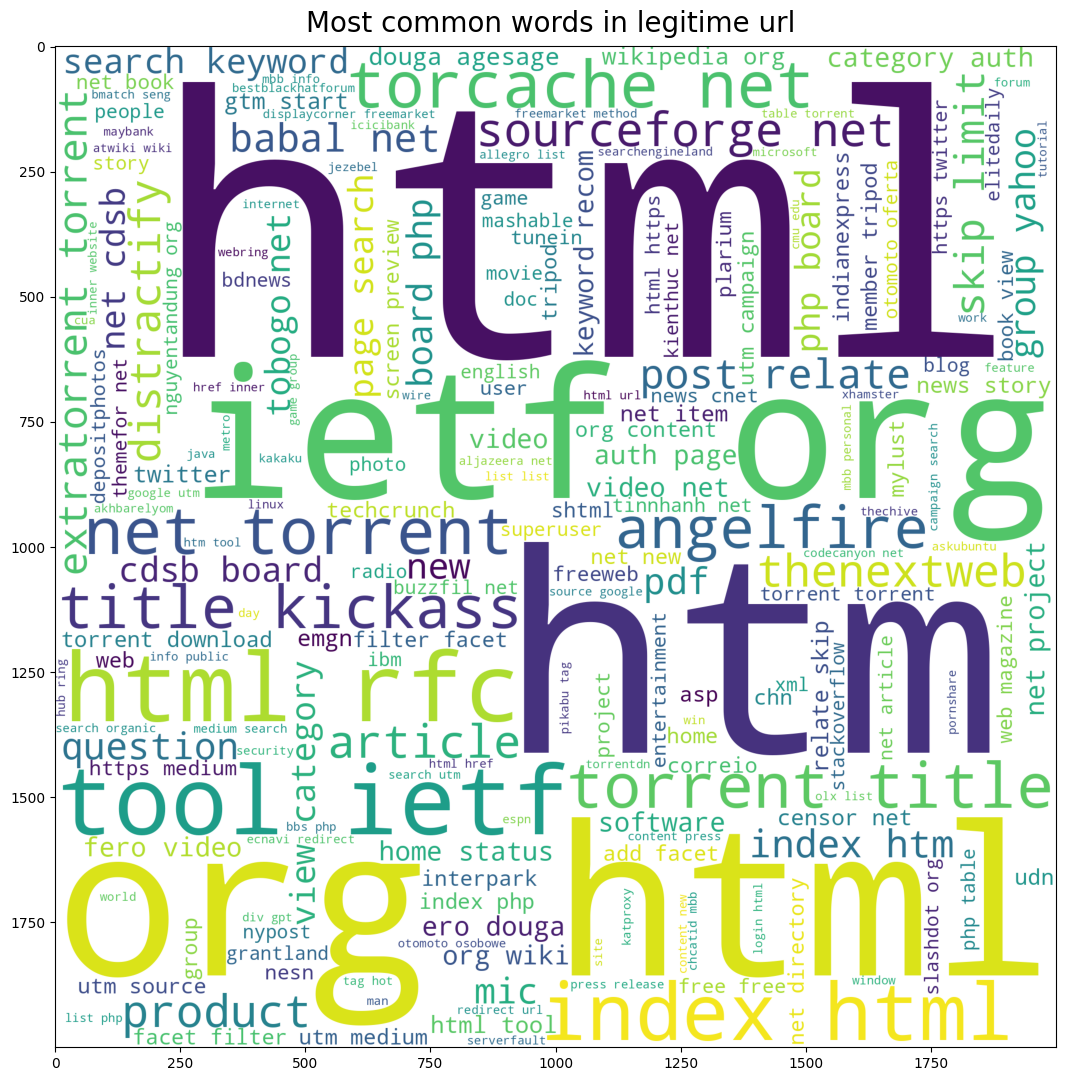

In [ ]:
from wordcloud import WordCloud
wc= WordCloud(width =2000, height=2000,min_font_size=10, background_color='white')
wc_0= wc.generate(data[data['label']==0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(13, 13))
plt.title("Most common words in legitime url ", fontdict={'size': 20, 'color': 'black','verticalalignment': 'bottom'})
plt.imshow(wc_0)

Dans le nuage de mots ci-dessus, les termes les plus fréquemment répétés sont clairement identifiables. Parmi eux, on retrouve des mots comme "torcache", "torrent", "ietf", "rfc", "kickass", "mic", "article", "product", "page", "search" et "index".
En effet, les termes comme "torcache", "torrent", "kickass" et "search" indiquent une activité associée à la recherche ou au partage de contenu en ligne, tandis que des termes comme "ietf" et "rfc" font référence à des protocoles et des normes de l'Internet. La présence de mots comme "product", "page" et "article" suggère également des URL qui pourraient être associées à des pages web commerciales ou à des articles en ligne.


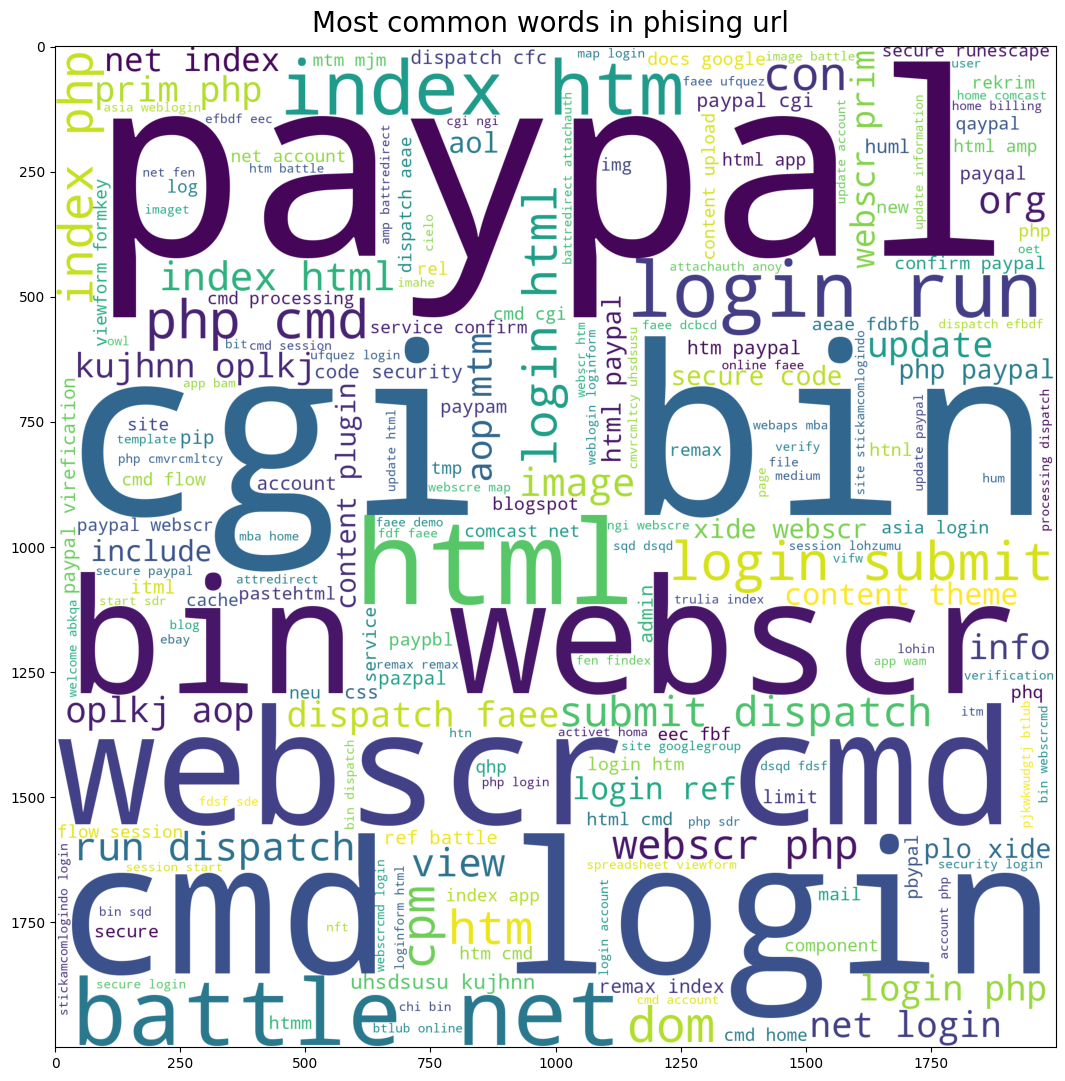

In [ ]:
from wordcloud import WordCloud
wc= WordCloud(width =2000, height=2000,min_font_size=10, background_color='white')
wc_1= wc.generate(data[data['label']==1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(13, 13))
plt.title("Most common words in phising url ", fontdict={'size': 20, 'color': 'black','verticalalignment': 'bottom'})
plt.imshow(wc_1)

Dans le nuage de mots ci-dessus, les termes les plus fréquemment répétés comprennent des mots tels que "paypal", "cmd", "index", "htm", "login", "webscr", "submitt", "dispatch", "login", "app", "cgi", "prim" et "qaypal".

Cette observation suggère fortement que les URL représentées dans ce nuage de mots sont potentiellement associées à des activités de phishing visant à tromper les utilisateurs de PayPal. Les termes comme "login", "webscr" et "cmd" sont des indicateurs courants de pages d'authentification ou de formulaires de connexion, tandis que des termes tels que "cgi" et "app" peuvent suggérer une tentative de création de pages ou d'applications malveillantes.

La présence fréquente de ces termes spécifiques à PayPal, combinée à d'autres termes comme "prim" et "qaypal", qui pourraient être des tentatives de fausse orthographe de "paypal", soulève des suspicions quant à l'authenticité de ces URL. Ces caractéristiques sont typiques des URL associées à des attaques de phishing, où les utilisateurs sont dirigés vers des sites frauduleux conçus pour voler leurs informations de connexion et leurs données personnelles.

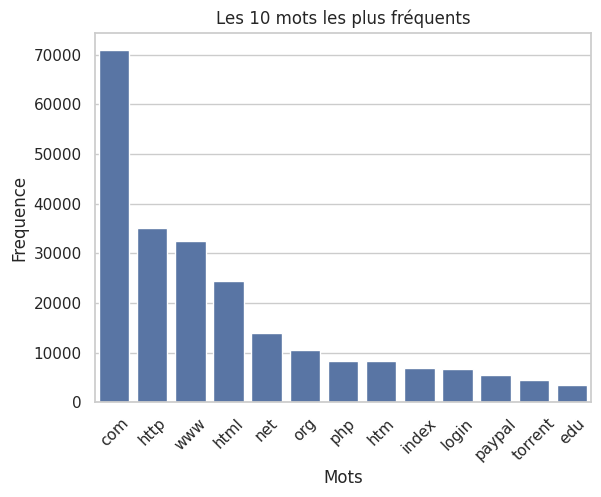

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the words by frequency in descending order
sorted_words = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 words and their frequencies
top_words = [word[0] for word in sorted_words[0:13]]
word_counts = [word[1] for word in sorted_words[0:13]]

# Create a barplot using Seaborn
sns.set(style="whitegrid")
ax = sns.barplot(x=top_words, y=word_counts)

# Set the title and axis labels
ax.set_title('Les 10 mots les plus fréquents')
ax.set_xlabel('Mots')
ax.set_ylabel('Frequence')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


Après avoir nettoyé les termes liés aux liens, tels que "www", "http", "html", "htm", "php" et "org", nous constatons que les mots les plus fréquemment répétés sont "http", "index", "login", "paypal" et "torrent".
Cela suggère que l'ensemble de données peut contenir une variété d'URL associées à des activités en ligne telles que l'accès à des comptes, des transactions financières ou le partage de fichiers. Cette compréhension des termes les plus fréquents peut guider notre analyse et notre traitement ultérieurs des données pour des tâches telles que la détection de phishing ou l'analyse de la légitimité des URL.






In [ ]:
# Créer un objet TfidfVectorizer
vectorizer = TfidfVectorizer( max_features = 5000) # max_features = 5000

# La fonction fit_transform de l'objet TfidfVectorizer calcule le score Tfidf pour chaque mot
tfidf_matrix = vectorizer.fit_transform(data.transformed_text)

tfidf_array = tfidf_matrix.toarray()

# Compute the sum of TF across all documents
tf_sum = tfidf_array.sum(axis=0)

# Create a dictionary that maps feature names to their TF sum values
feature_tfidf_sum_dict = dict(zip(vectorizer.get_feature_names_out(), tf_sum))

# Sort the dictionary by TF sum values in descending order
sorted_feature_tfidf_sum_dict = sorted(feature_tfidf_sum_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names from the sorted dictionary in the desired order
sorted_feature_names = [feature_tfidf_sum[0] for feature_tfidf_sum in sorted_feature_tfidf_sum_dict]

In [ ]:
my_dict = dict(sorted_feature_tfidf_sum_dict)
# create a new DataFrame with the tf-idf features
df_tfidf = pd.DataFrame(tfidf_array, columns=my_dict.keys())
df_tfidf


,com,www,html,http,net,org,htm,index,php,tool,...,etiqacontent,pekerjaan,fspreadsheet,ndplr,fformkey,fviewform,warsztaty,bch,kmdata,bchapter
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Après avoir généré la matrice TF-IDF, je vais entreprener une analyse des composantes principales (PCA) pour condenser les informations des différentes colonnes en seulement 10 colonnes principales.
De plus, en résumant les données en 10 colonnes principales, je vais simplifier leur interprétation tout en préservant les relations importantes entre les caractéristiques. Cela peut faciliter l'analyse exploratoire des données et la compréhension des patterns sous-jacents, tout en laissant de côté les informations moins pertinentes,
Enfin, cette approche peut également être utile pour l'entraînement de modèles de machine learning, en réduisant le temps de calcul nécessaire et en améliorant potentiellement la performance du modèle en éliminant le bruit et en mettant en évidence les caractéristiques les plus discriminantes.

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=10)

In [ ]:
X_pca = pca.fit_transform(df_tfidf)

In [ ]:
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2','PC3','PC4','PC5','PC6', 'PC7','PC8','PC9','PC10'])
df['label'] = data['label']

In [ ]:
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,label
0,-0.055813,-0.033869,0.025263,0.116885,-0.105916,0.133628,0.022582,-0.098175,-0.021713,-0.062710,0
1,-0.139136,-0.070828,-0.041151,-0.022691,-0.046450,-0.026490,-0.026803,-0.001788,-0.012178,-0.021712,0
2,-0.145123,-0.085696,-0.044395,-0.015803,-0.042523,-0.031214,-0.047751,-0.017749,-0.020328,-0.013741,0
3,0.005389,0.039232,-0.064528,-0.016509,-0.021609,-0.070003,-0.041031,-0.013110,-0.017231,0.010280,0
4,-0.029246,-0.064453,-0.054551,-0.149709,0.002872,0.162515,-0.069721,0.049015,0.021095,0.038911,1


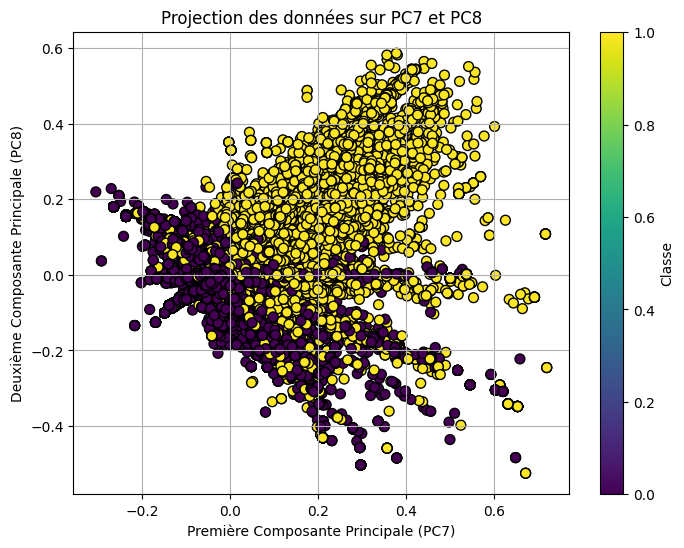

In [67]:
import matplotlib.pyplot as plt

# Tracer les points dans les deux premières composantes principales (PC7 et PC8)
plt.figure(figsize=(8, 6))
plt.scatter(df['PC7'], df['PC8'], c=df['label'], cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Première Composante Principale (PC7)')
plt.ylabel('Deuxième Composante Principale (PC8)')
plt.title('Projection des données sur PC7 et PC8')
plt.colorbar(label='Classe')
plt.grid(True)
plt.show()


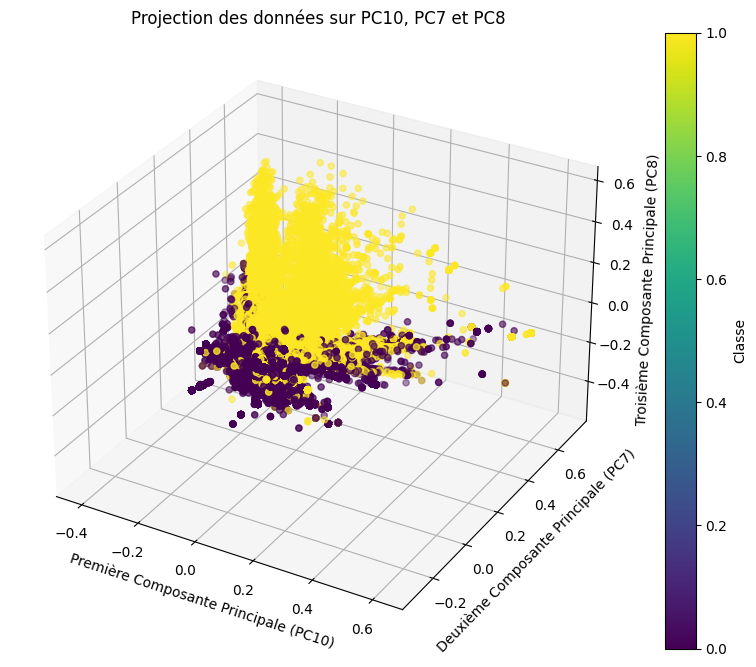

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


x = df['PC10']
y = df['PC7']
z = df['PC8']
colors = df['label']

# Tracer les points dans l'espace 3D
ax.scatter(x, y, z, c=colors, cmap='viridis', marker='o')

# Définir les étiquettes des axes
ax.set_xlabel('Première Composante Principale (PC10)')
ax.set_ylabel('Deuxième Composante Principale (PC7)')
ax.set_zlabel('Troisième Composante Principale (PC8)')
ax.set_title('Projection des données sur PC10, PC7 et PC8')

# Afficher la légende de la couleur
cbar = plt.colorbar(ax.scatter([], [], [], c=[], cmap='viridis'))
cbar.set_label('Classe')

plt.show()

In [ ]:
# Afficher la quantité d'information expliquée par chaque composante principale
print("Quantité d'information expliquée par chaque composante principale:")
for i, explained_variance_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Composante principale {i+1}: {explained_variance_ratio:.2f}")


Quantité d'information expliquée par chaque composante principale:
Composante principale 1: 0.06
Composante principale 2: 0.04
Composante principale 3: 0.03
Composante principale 4: 0.02
Composante principale 5: 0.02
Composante principale 6: 0.01
Composante principale 7: 0.01
Composante principale 8: 0.01
Composante principale 9: 0.01
Composante principale 10: 0.01


Les deux graphiques ci-dessus indiquent que les classes phishing et légitime peuvent être distinctement séparées.

Cette clarté dans la séparation des classes est prometteuse, suggérant que la PCA a réussi à saisir les caractéristiques distinctives des URL phishing et légitimes dans un espace de dimensions réduit.

Pour une analyse plus complète, d'autres facteurs seront pris en considération. Ainsi, nous chercherons à capturer d'autres paramètres pertinents à partir des URL.

In [ ]:

def count_special_characters(url):
    count = 0
    delim=[';','_','?','=','&','.','']
    for each in url:
        if each in delim:
            count = count + 1

    return count


In [ ]:
df['special_cha']=raw_data['domain'].apply(lambda x: count_special_characters(x))

<Figure size 1000x600 with 0 Axes>

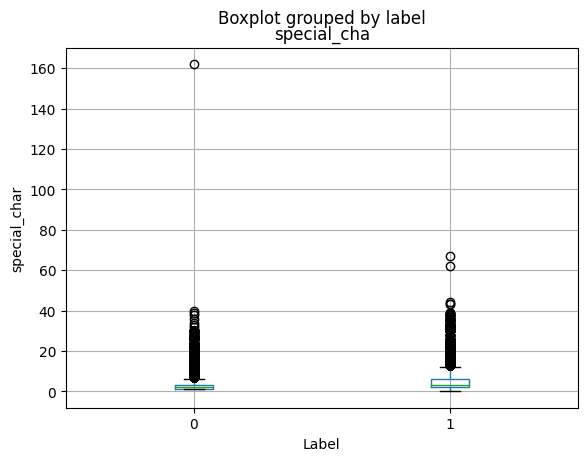

In [ ]:
# Tracer le boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column='special_cha', by='label')

plt.xlabel("Label")
plt.ylabel("special_char")

plt.grid(True)
plt.show()

Selon l'analyse du box plot, il est observé que la distribution des caractères spéciaux est similaire pour les URL légitimes et les URL de phishing. Cette constatation suggère que le nombre de caractères spéciaux n'a pas un impact significatif sur la distinction entre les deux types d'URL.

In [ ]:
df=df.drop(['special_cha'], axis=1)

On abordera un autre type de caractère spécial :

L'utilisation du symbole "@" dans l'URL amène le navigateur à ignorer tout ce qui précède le symbole "@" et l'adresse réelle suit souvent le symbole "@".

La présence de "//" dans le chemin de l'URL signifie que l'utilisateur sera redirigé vers un autre site web.


In [ ]:
def isPresentAt(url):
    compt=url.count('@')
    return (url.count('//')+compt)/10

In [ ]:
df['is_pres']=raw_data['domain'].apply(lambda x: isPresentAt(x))

<Figure size 1000x600 with 0 Axes>

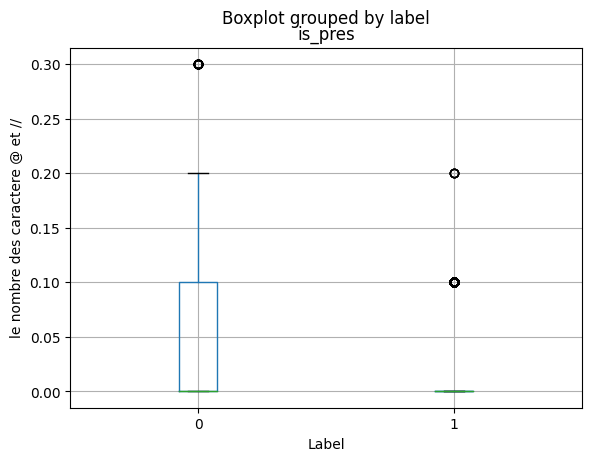

In [ ]:
plt.figure(figsize=(10, 6))
df.boxplot(column='is_pres', by='label')

plt.xlabel("Label")
plt.ylabel("le nombre des caractere @ et //")

plt.grid(True)
plt.show()

Il est observé que dans le cas du phishing, les caractères "@" et "//" sont peu présents, à l'exception de deux cas, tandis que dans les liens légitimes, ces caractères sont largement utilisés.
Cela peut indiquer une différence significative dans les schémas de construction entre les deux types de URL, ce qui peut être utile pour identifier et filtrer les tentatives de phishing.

je deviserai par 10 afin d'assurer le scaling entre les differentes colonnes.

Un service de raccourcissement d'URL est un outil en ligne qui permet de réduire la longueur d'une URL en la remplaçant par un lien plus court, plus facile à partager ou à mémoriser.


In [ ]:
def short_service(url):
    patterns = [
        r'bit\.ly', r'goo\.gl', r'shorte\.st', r'go2l\.ink', r'x\.co', r'ow\.ly', r't\.co', r'tinyurl', r'tr\.im', r'is\.gd',
        r'cli\.gs', r'yfrog\.com', r'migre\.me', r'ff\.im', r'tiny\.cc', r'url4\.eu', r'twit\.ac', r'su\.pr', r'twurl\.nl',
        r'snipurl\.com', r'short\.to', r'BudURL\.com', r'ping\.fm', r'post\.ly', r'Just\.as', r'bkite\.com', r'snipr\.com',
        r'fic\.kr', r'loopt\.us', r'doiop\.com', r'short\.ie', r'kl\.am', r'wp\.me', r'rubyurl\.com', r'om\.ly', r'to\.ly',
        r'bit\.do', r't\.co', r'lnkd\.in', r'db\.tt', r'qr\.ae', r'adf\.ly', r'goo\.gl', r'bitly\.com', r'cur\.lv', r'tinyurl\.com',
        r'ow\.ly', r'bit\.ly', r'ity\.im', r'q\.gs', r'is\.gd', r'po\.st', r'bc\.vc', r'twitthis\.com', r'u\.to', r'j\.mp',
        r'buzurl\.com', r'cutt\.us', r'u\.bb', r'yourls\.org', r'x\.co', r'prettylinkpro\.com', r'scrnch\.me', r'filoops\.info',
        r'vzturl\.com', r'qr\.net', r'1url\.com', r'tweez\.me', r'v\.gd', r'tr\.im', r'link\.zip\.net', r'tiny\.cc', r'snip\.ly',
        r'tr\.im', r'shorturl\.at', r'lnkd\.in', r'v\.tc', r'qr\.ae', r't\.co', r'ht\.ly', r'w\.ly', r'bit\.do', r'ow\.ly',
        r'sh\.st', r'xurl\.es', r'cur\.lv', r'q\.ps', r'po\.st', r'bc\.vc', r'twitthis\.com', r'u\.bb', r'yourls\.org',
        r'prettylinkpro\.com', r'scrnch\.me', r'filoops\.info', r'vzturl\.com', r'qr\.net', r'1url\.com', r'v\.gd', r'tr\.im',
        r'link\.zip\.net'
    ]

    for pattern in patterns:
        if re.search(pattern, url):
            return 1
    return 0

Cette fonction recherche une correspondance entre l'URL fournie et une liste de motifs réguliers qui représentent les domaines couramment utilisés par les services de raccourcissement d'URL. Si une correspondance est trouvée, la fonction renvoie 1, sinon elle renvoie 0. Vous pouvez ajuster cette fonction selon vos besoins pour l'intégrer dans votre application ou votre script de détection de phishing.

In [ ]:
df['short_service']=raw_data['domain'].apply(lambda x: short_service(x))

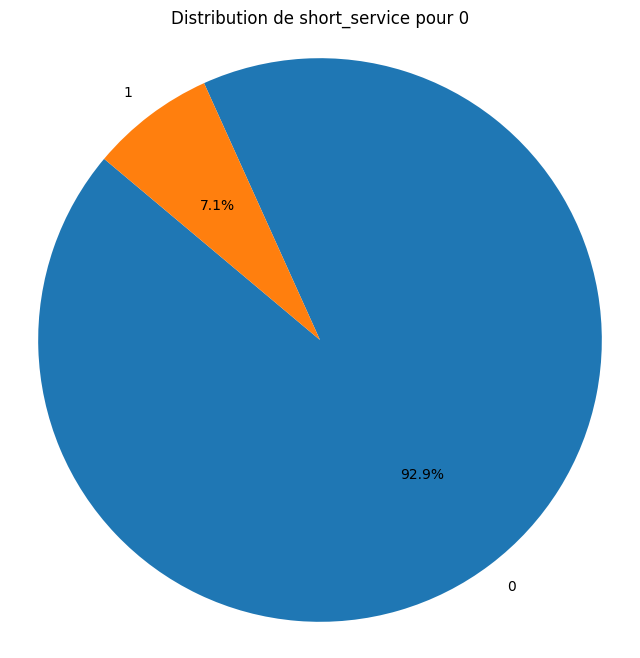

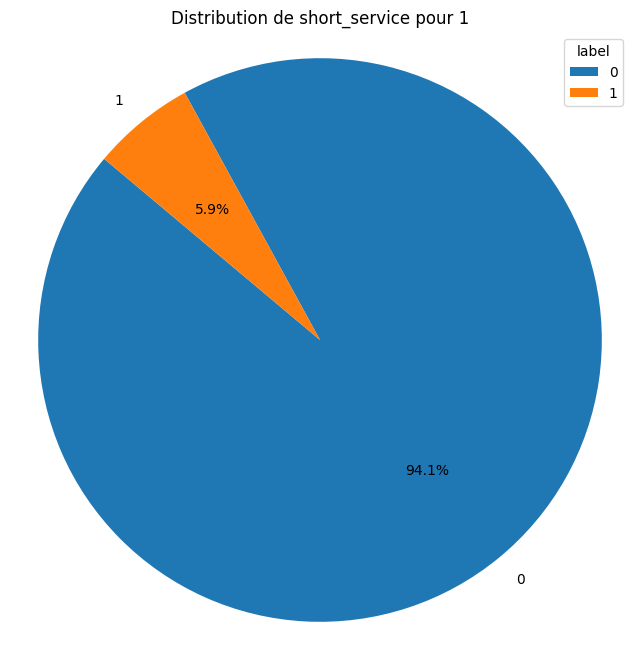

In [ ]:
pivot_table = df.groupby(['short_service','label']).size().unstack()

# Création d'un graphique en barres empilées pour visualiser la distribution


for label in pivot_table.columns:
    plt.figure(figsize=(8, 8))
    plt.pie(pivot_table[label], labels=pivot_table.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Distribution de short_service pour {label}')
    plt.axis('equal')
plt.legend(title='label', loc='upper right')
plt.show()

In [ ]:
df=df.drop(['short_service'], axis=1)

Selon les données présentées dans le graphique, il apparaît que la présence ou l'absence de services de raccourcissement d'URL (short_Services) n'a pas de conséquence marquée sur la distribution entre les activités de phishing et les activités légitimes. En d'autres termes, l'utilisation d'un service de raccourcissement semble ne pas avoir d'impact sur la probabilité qu'une URL soit associée à une activité de phishing ou à une activité légitime.

In [ ]:
from urllib.parse import urlparse
def http_secure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        return 1
    else:
        return 0

In [ ]:
df['httpsecure'] = raw_data['domain'].apply(lambda x: http_secure(x))

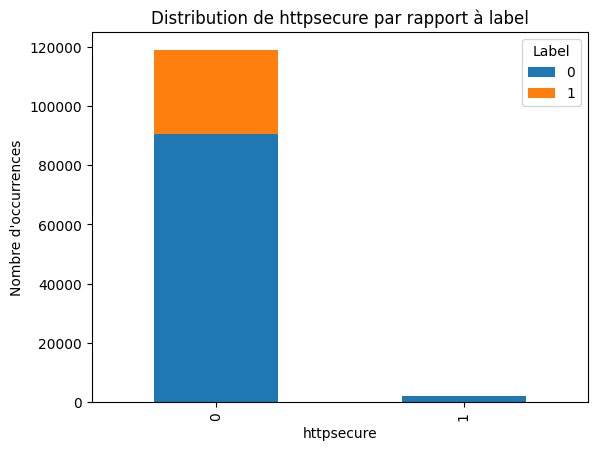

In [ ]:
pivot_table = df.groupby(['httpsecure','label']).size().unstack()

# Création d'un graphique en barres empilées pour visualiser la distribution
pivot_table.plot(kind='bar', stacked=True)

# Ajout de légendes et de titres
plt.title('Distribution de httpsecure par rapport à label')
plt.xlabel('httpsecure')
plt.ylabel('Nombre d\'occurrences')

# Afficher le graphique
plt.legend(title='Label')
plt.show()

D'apres le graphe :

-Lorsque 'httpsecure' est égal à 1 (ce qui signifie que l'URL contient HTTPS), il est plus probable que l'URL soit légitime.

-Lorsque 'httpsecure' est égal à 0, on a  environ 3/4 de chance que le site soit légitime et 1/4 de chance que le site soit un phishing.

In [ ]:
def lendomain(url):
    dom=urlparse(url).hostname
    if dom == None :
      return 0
    else :
      return len(dom)/100

def lenpath(url):
    pth = urlparse(url).path
    if pth == None :
      return 0
    else :
      return len(pth)/10000


J'ai choisi de diviser par 100 et par 10 000 respectivement les valeurs des colonnes "len_path" et "len_domain" afin d'effectuer une mise à l'échelle. Cela garantira que les différentes valeurs de la matrice se trouvent dans le même ordre de grandeur.


In [ ]:
df['len_domain'] = raw_data['domain'].apply(lambda x: lendomain(x))
df['len_path'] = raw_data['domain'].apply(lambda x: lenpath(x))


<Figure size 1000x600 with 0 Axes>

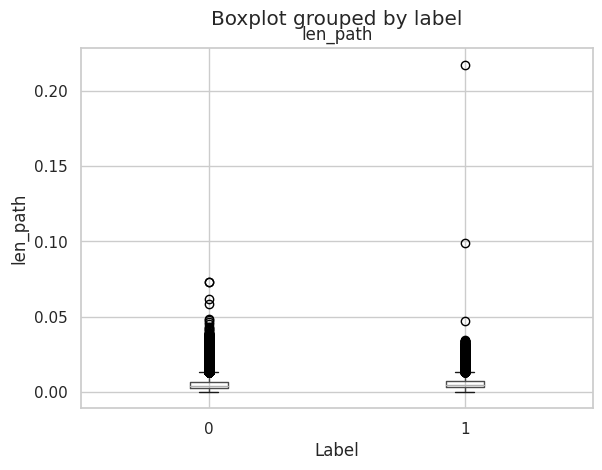

In [ ]:


# Tracer le boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column='len_path', by='label')

plt.xlabel("Label")
plt.ylabel("len_path")

plt.grid(True)
plt.show()


Selon la boîte à moustache, la longueur du chemin dans un URL ne constitue pas un critère fiable pour différencier les tentatives de phishing des URL légitimes. Cependant, cette mesure peut être prise en compte lorsqu'elle est combinée avec une analyse plus approfondie du chemin de l'URL.

<Figure size 1000x600 with 0 Axes>

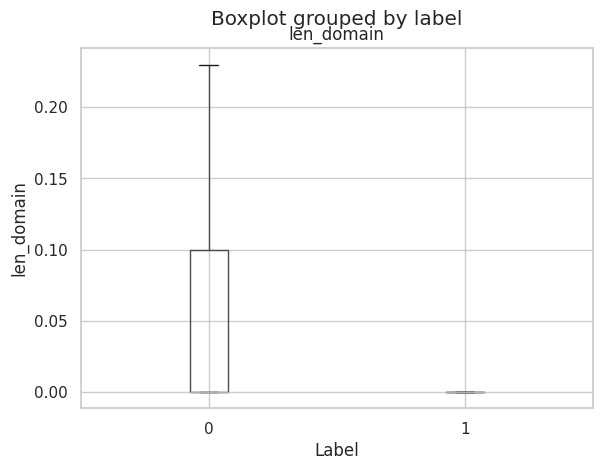

In [ ]:


# Tracer le boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column='len_domain', by='label')

plt.xlabel("Label")
plt.ylabel("len_domain")

plt.grid(True)
plt.show()


Il est observé que les URL associées au phishing ont une longueur de domaine de zéro, ce qui signifie qu'aucun nom de domaine n'est présent. Alors la dissimulation du nom de domaine dans un lien peut être un indicateur de phishing

<Axes: >

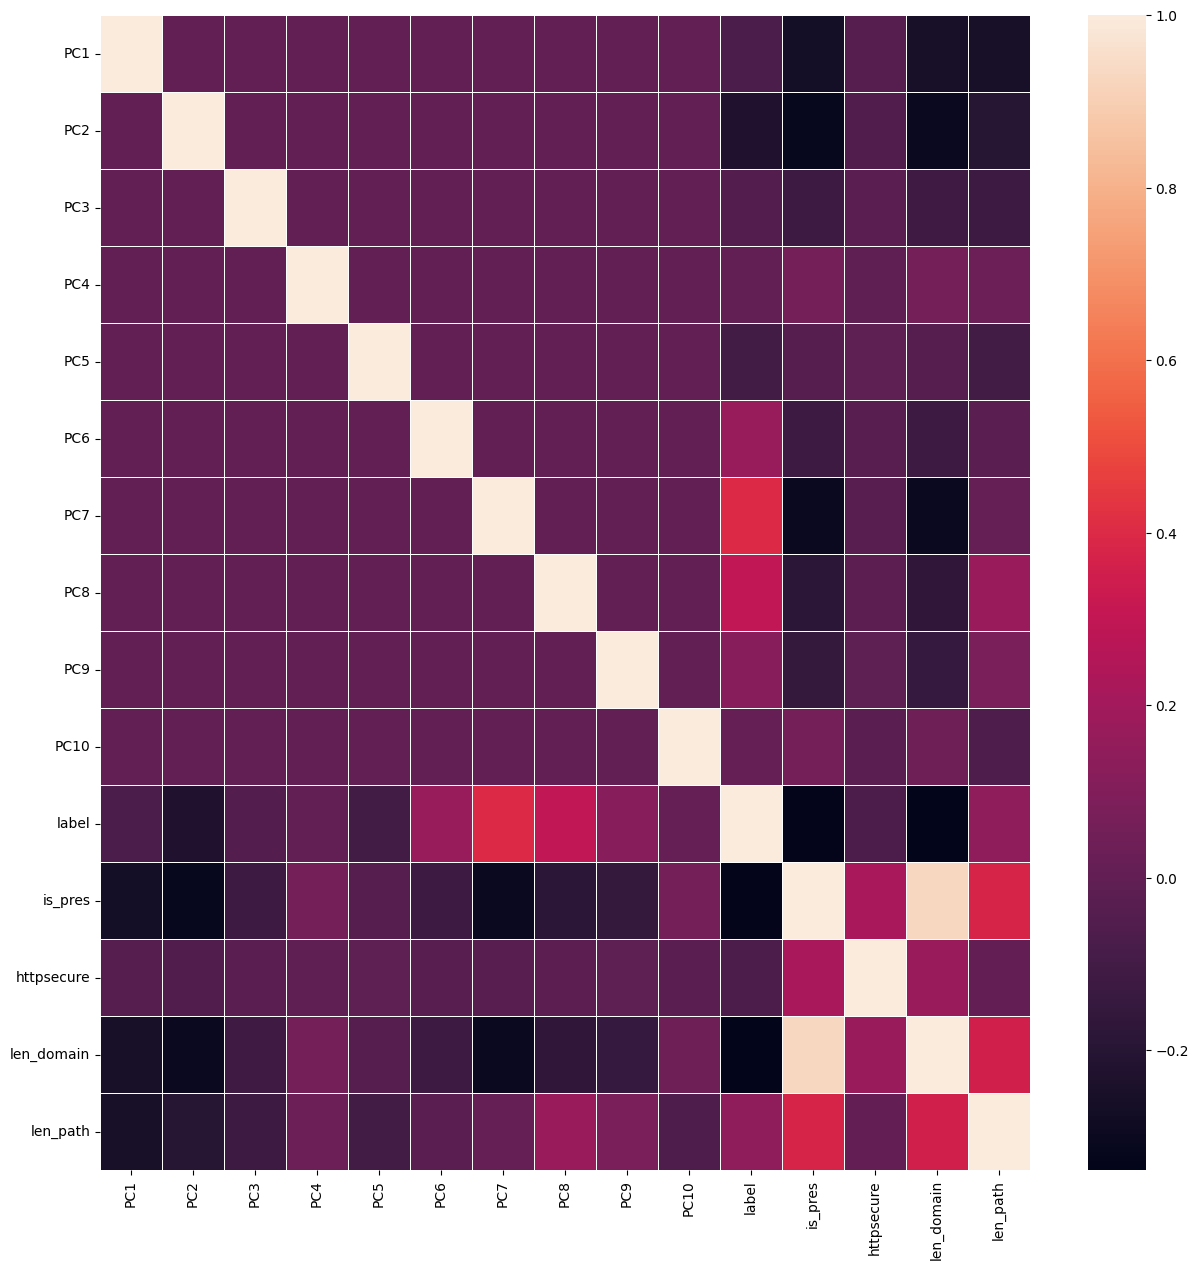

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), linewidths=.5)

La heatmap ci-dessus offre un aperçu de la corrélation entre notre variable cible (label) et les autres variables explicatives. Les 10 composantes principales sont extraites d'une Analyse en Composantes Principales (ACP) appliquée sur la matrice TF-IDF lors de l'analyse du texte. Les autres colonnes représentent les différentes caractéristiques abordées dans les parties précédentes.

La longueur du domaine et la deuxième composante présentent une corrélation négative avec la variable cible.

Les composantes 6, 7 et 8 sont positivement corrélées avec la variable cible.

Les composantes 1, 2 et 7 montrent une corrélation négative avec la longueur du domaine.

In [ ]:
df.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,label,is_pres,httpsecure,len_domain,len_path
count,1.209900e+05,1.209900e+05,1.209900e+05,1.209900e+05,1.209900e+05,1.209900e+05,1.209900e+05,1.209900e+05,1.209900e+05,1.209900e+05,120990.000000,120990.000000,120990.000000,120990.000000,120990.000000
mean,-2.203004e-15,2.100224e-15,-3.030811e-15,-3.218056e-15,6.605070e-16,-2.606380e-15,1.302676e-15,-8.661116e-16,-9.981583e-16,-1.151945e-15,0.233986,0.030217,0.016117,0.034519,0.005123
std,2.427686e-01,1.871545e-01,1.674719e-01,1.249126e-01,1.194606e-01,1.174572e-01,9.978825e-02,9.329380e-02,8.852793e-02,8.256412e-02,0.423365,0.047165,0.125926,0.056277,0.003925
min,-2.628128e-01,-2.800126e-01,-3.684520e-01,-6.203257e-01,-3.376559e-01,-2.928344e-01,-3.060615e-01,-5.244992e-01,-4.177914e-01,-4.156118e-01,0.000000,0.000000,0.000000,0.000000,0.000100
25%,-1.395880e-01,-1.020708e-01,-6.417113e-02,-3.139652e-02,-4.858407e-02,-3.439914e-02,-5.082658e-02,-2.845493e-02,-2.711814e-02,-2.547771e-02,0.000000,0.000000,0.000000,0.000000,0.002700
50%,-7.326169e-02,-7.244667e-02,-3.099569e-02,-1.624293e-02,-3.187649e-02,-2.202934e-02,-2.089562e-02,-4.965411e-03,-7.189028e-03,-1.083837e-02,0.000000,0.000000,0.000000,0.000000,0.004000
75%,2.377329e-02,7.677889e-02,7.554612e-03,2.895048e-02,2.187092e-02,-1.374698e-03,1.504447e-02,2.551370e-02,1.915682e-02,2.163510e-02,0.000000,0.100000,0.000000,0.090000,0.006900
max,8.153874e-01,8.391275e-01,8.689023e-01,6.694493e-01,8.169575e-01,8.939575e-01,7.202771e-01,5.859791e-01,5.829783e-01,6.226169e-01,1.000000,0.300000,1.000000,0.230000,0.217500


Le rééquilibrage des données vise à corriger les déséquilibres dans la distribution des classes dans un ensemble de données. Il permet d'améliorer la performance des modèles en atténuant le biais en faveur des classes majoritaires et en permettant une meilleure généralisation sur de nouvelles données.

En réduisant le risque de surapprentissage et en fournissant des résultats plus équilibrés, le rééquilibrage des données contribue à une interprétation plus précise des performances du modèle.

Dans notre cas, je vais utilisé la SMOTE (Synthetic Minority Over-sampling Technique)  ,C'est une méthode populaire en statistique pour traiter les problèmes de déséquilibre de classe. SMOTE génère synthétiquement de nouveaux exemples de la classe minoritaire en interpolant des points entre les exemples existants, ce qui augmente la taille de l'ensemble de données de la classe minoritaire tout en préservant sa structure sous-jacente




In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(df.drop(['label'],axis=1), df['label'])

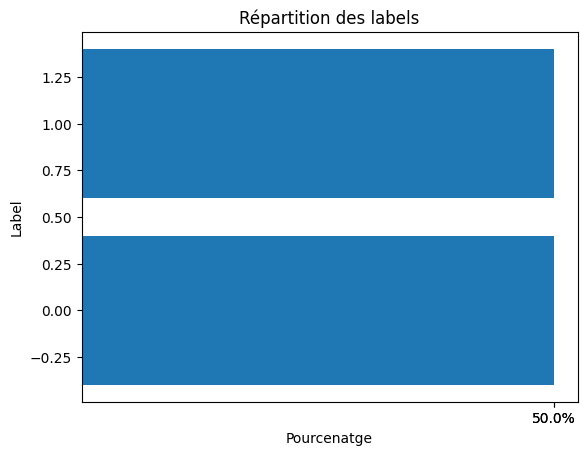

In [ ]:
counts = y_resampled.value_counts(normalize=True)

# Créer un graphique à barres horizontales
plt.barh(counts.index, counts.values)

# Ajouter les pourcentages sur l'axe des x
plt.xticks(ticks=[i for i in counts.values], labels=[f'{round(i*100,2)}%' for i in counts.values])

# Ajouter un titre et des labels pour les axes
plt.title('Répartition des labels')
plt.xlabel('Pourcenatge')
plt.ylabel('Label')

# Afficher le graphique
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np


Diviser le dataset en trois parties distinctes :

Partie d'entraînement : Cette partie est utilisée pour entraîner les modèles.

Partie de test : Cette partie est utilisée pour évaluer les performances des modèles une fois qu'ils ont été entraînés.

Partie de validation pour le stacking : Cette partie est utilisée spécifiquement dans le cadre du stacking (empilement) de modèles

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

**Modeles de classification**

Dans la phase de classification, j'ai utilisé trois modèles bien renommé pour résoudre des problèmes de classification : XGBoost, Random Forest et Bagging Classifier. J'ai choisi d'optimiser les performances de ces modèles en effectuant un fine-tuning minutieux de leurs paramètres en untilisant les deux methodes de recherche aleatoire et Grid. Cette approche m'a permis d'ajuster les hyperparamètres de chaque modèle afin d'obtenir les meilleures performances possibles.

Ensuite, j'ai combiné ces trois modèles en utilisant une approche de stacking. Cette technique consiste à agréger les prédictions de chaque modèle de base à l'aide d'un métamodèle, dans ce cas la régression logistique. Cette fusion permet d'exploiter les forces individuelles de chaque modèle, ce qui améliore généralement la précision globale de la classification.

Une fois cette étape de stacking achevée, j'ai également exploré l'utilisation d'un modèle simple de deep learning . L'objectif était d'évaluer si un réseau de neurones pouvait surpasser ou compléter les performances des modèles classiques dans cette application spécifique.

En ce qui concerne le choix des paramètres, j'ai décidé de ne pas augmenter leur nombre en raison de contraintes de ressources computationnelles limitées. Cette décision était nécessaire pour garantir que le processus reste efficace tout en évitant une surcharge des ressources disponibles, ce qui aurait pu compromettre les performances globales du système.






**Métriques d'évaluation**

Pour comparer les performances des modèles, j'ai choisi d'utiliser des métriques bien établies qui permettent de surveiller de près la distribution et la répartition des résultats de classification. Ces métriques incluent :

La précision mesure la proportion d'instances correctement classées parmi toutes les instances classées positivement par le modèle.

Le rappel quant à lui évalue la proportion d'instances positives correctement identifiées parmi toutes les instances réellement positives dans les données.

Le score F1 est la moyenne harmonique entre la précision et le rappel, fournissant une mesure globale de l'exactitude du modèle.

Le support indique le nombre d'occurrences de chaque classe dans l'ensemble de données.

Les moyennes macro et pondérées fournissent des moyennes des métriques individuelles calculées pour chaque classe.

La moyenne macro calcule la moyenne non pondérée des métriques pour chaque classe, tandis que la moyenne pondérée calcule la moyenne des métriques en tenant compte du support de chaque classe.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
# Définir la grille des hyperparamètres à optimiser
param_grid = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 1000),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': [0, 1, 5]
}

# Initialiser le classificateur XGBoost
xgb = XGBClassifier()

# Initialiser la recherche aléatoire
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=30, scoring='accuracy', cv=2, verbose=2, random_state=42, n_jobs=-1)

# Exécuter la recherche aléatoire sur les données d'entraînement
random_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", random_search.best_params_)
print("Meilleur score:", random_search.best_score_)

# Entraîner le modèle final avec les meilleurs hyperparamètres
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Meilleurs paramètres: {'colsample_bytree': 0.9627313766183017, 'gamma': 0, 'learning_rate': 0.07838054876258249, 'max_depth': 8, 'n_estimators': 732, 'subsample': 0.9272059063689972}
Meilleur score: 0.962100649076962


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9627313766183017, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07838054876258249, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=732, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Test Accuracy :  96.60%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     14728
           1       0.96      0.97      0.97     14930

    accuracy                           0.97     29658
   macro avg       0.97      0.97      0.97     29658
weighted avg       0.97      0.97      0.97     29658

             Confusion_matrix 


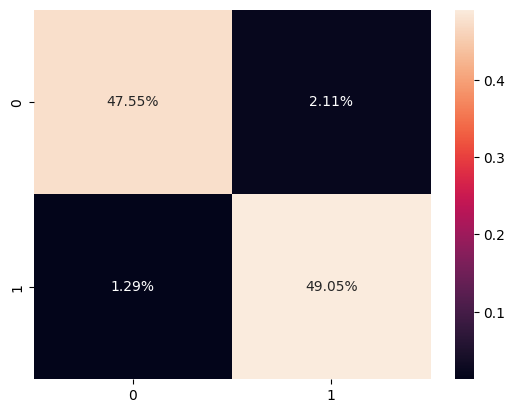

###################- End -###################


In [ ]:
model_=best_xgb
pred = model_.predict(X_test)
acc = accuracy_score(pred, y_test)

print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test, pred))
print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()
print('\033[31m###################- End -###################\033[0m')

ces résultats indiquent que le modèle présente de très bonnes performances dans la classification des deux classes, avec une précision, un rappel et un score F1 élevés pour chaque classe. L'exactitude globale du modèle est de 97 %, ce qui suggère une classification très précise sur l'ensemble des données.

In [ ]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification




param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf_classifier = RandomForestClassifier(random_state=42)


rf_grid_search = RandomizedSearchCV(rf_classifier, param_distributions=param_grid, n_iter=1, scoring='accuracy', cv=2, verbose=2, random_state=42, n_jobs=-1)

rf_grid_search.fit(X_train, y_train)


print("Meilleurs hyperparamètres:")
print(rf_grid_search.best_params_)


best_rf_model = rf_grid_search.best_estimator_




Fitting 2 folds for each of 1 candidates, totalling 2 fits
Meilleurs hyperparamètres:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


Test Accuracy :  96.22%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     14728
           1       0.95      0.97      0.96     14930

    accuracy                           0.96     29658
   macro avg       0.96      0.96      0.96     29658
weighted avg       0.96      0.96      0.96     29658

             Confusion_matrix 


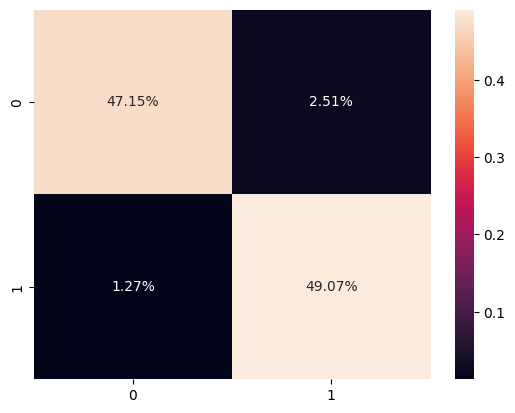

###################- End -###################


In [ ]:
model_rf=best_rf_model
pred = model_rf.predict(X_test)
acc = accuracy_score(pred, y_test)

print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test, pred))
print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()
print('\033[31m###################- End -###################\033[0m')


bien que les performances du modèle restent élevées avec une précision globale de 96,22 %, on remarque une légère baisse par rapport au xgboost. Cela peut être dû à des fluctuations normales dans les performances du modèle ou à des variations dans les données de test. Néanmoins, le modèle demeure robuste avec des valeurs équilibrées de précision, de rappel et de score F1 pour les deux classes.

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


base_classifier = DecisionTreeClassifier()


bagging_classifier = BaggingClassifier(estimator=base_classifier)


param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0]
}


grid_search_bagg = RandomizedSearchCV(bagging_classifier, param_distributions=param_grid, n_iter=1, scoring='accuracy', cv=2, verbose=2, random_state=42, n_jobs=-1)


grid_search_bagg.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2,
                   estimator=BaggingClassifier(estimator=DecisionTreeClassifier()),
                   n_iter=1, n_jobs=-1,
                   param_distributions={'max_features': [0.5, 0.7, 1.0],
                                        'max_samples': [0.5, 0.7, 1.0],
                                        'n_estimators': [10, 50, 100]},
                   random_state=42, scoring='accuracy', verbose=2)

Test Accuracy :  96.33%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     14728
           1       0.96      0.97      0.96     14930

    accuracy                           0.96     29658
   macro avg       0.96      0.96      0.96     29658
weighted avg       0.96      0.96      0.96     29658

             Confusion_matrix 


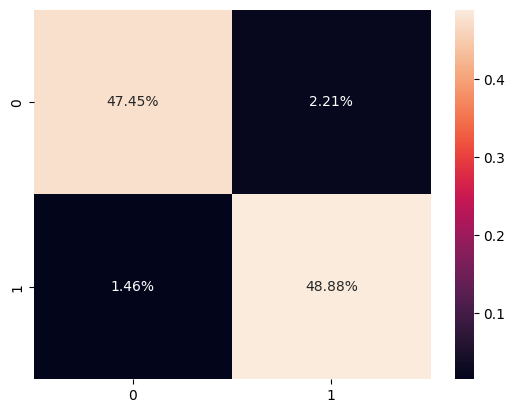

###################- End -###################


In [ ]:
model_bagg=grid_search_bagg.best_estimator_
pred = model_bagg.predict(X_test)
acc = accuracy_score(pred, y_test)

print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test, pred))
print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()
print('\033[31m###################- End -###################\033[0m')

Comme avec les autres modèles, nous observons des scores élevés de précision, de rappel et de score F1 pour les deux classes.
L'accuracy est également comparable,le modèle Bagging Classifier affiche des performances robustes et compétitives dans la classification des deux classes, avec des scores équilibrés de précision et de rappel.

In [45]:
# Make predictions on the validation set
xgb_pred = model_.predict(X_test)
rf_pred = model_rf.predict(X_test)
bagg_pred = model_bagg.predict(X_test)

In [46]:
from sklearn.linear_model import LogisticRegression

# Combine the predictions of the base models into a single feature matrix
X_val_meta = np.column_stack((xgb_pred , rf_pred, bagg_pred))

# Train the meta-model on the combined feature matrix and the target values
meta_model = LogisticRegression()
meta_model.fit(X_val_meta, y_test)

LogisticRegression()

In [47]:
dt_pred_new = model_.predict(X_val)
rf_pred_new = model_rf.predict(X_val)
gb_pred_new = model_bagg.predict(X_val)

In [48]:
# Combine the predictions of the base models into a single feature matrix
X_new_meta = np.column_stack((dt_pred_new, rf_pred_new, gb_pred_new))

# Make a prediction using the meta-model
y_new_pred = meta_model.predict(X_new_meta)

Test Accuracy :  96.53%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     18486
           1       0.96      0.97      0.97     18586

    accuracy                           0.97     37072
   macro avg       0.97      0.97      0.97     37072
weighted avg       0.97      0.97      0.97     37072

             Confusion_matrix 


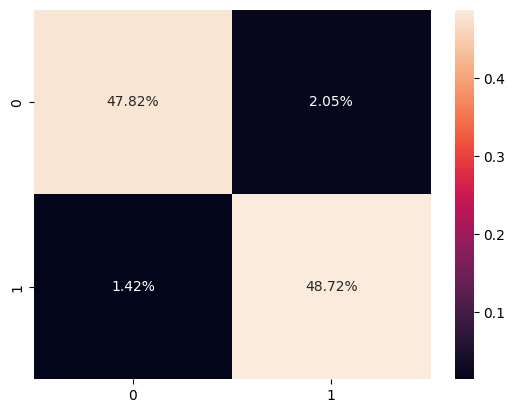

In [49]:
    acc = accuracy_score(y_new_pred, y_val)
    #accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_val, y_new_pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_val, y_new_pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')

 le modèle de stacking avec régression logistique constitue une autre approche efficace pour la classification des données. Il présente des performances similaires aux autres modèles évalués, offrant une précision élevée et une capacité à généraliser correctement sur de nouvelles données.

In [82]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers


model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history=model.fit(X_train, y_train, epochs=30, batch_size=50, validation_data=(X_test, y_test))

Epoch 1/30
2373/2373 [==============================] - 16s 5ms/step - loss: 0.2553 - accuracy: 0.8898 - val_loss: 0.2229 - val_accuracy: 0.8986
Epoch 2/30
2373/2373 [==============================] - 6s 2ms/step - loss: 0.2057 - accuracy: 0.9069 - val_loss: 0.2010 - val_accuracy: 0.9092
Epoch 3/30
2373/2373 [==============================] - 6s 3ms/step - loss: 0.1916 - accuracy: 0.9159 - val_loss: 0.1911 - val_accuracy: 0.9145
Epoch 4/30
2373/2373 [==============================] - 7s 3ms/step - loss: 0.1847 - accuracy: 0.9191 - val_loss: 0.1833 - val_accuracy: 0.9194
Epoch 5/30
2373/2373 [==============================] - 6s 3ms/step - loss: 0.1802 - accuracy: 0.9219 - val_loss: 0.1882 - val_accuracy: 0.9179
Epoch 6/30
2373/2373 [==============================] - 7s 3ms/step - loss: 0.1757 - accuracy: 0.9240 - val_loss: 0.1956 - val_accuracy: 0.9048
Epoch 7/30
2373/2373 [==============================] - 6s 3ms/step - loss: 0.1723 - accuracy: 0.9265 - val_loss: 0.1690 - val_accuracy

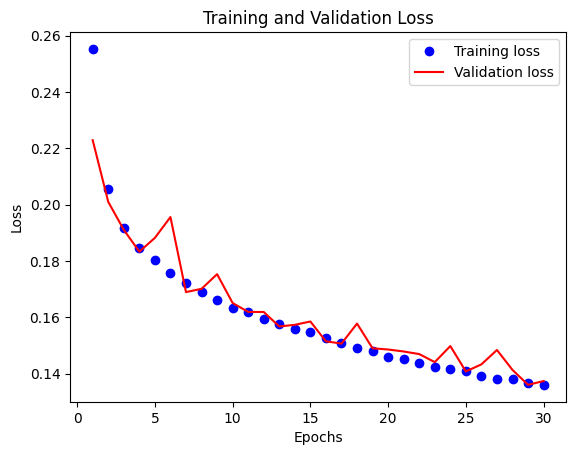

In [83]:

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

La similarité des courbes de perte entre l'ensemble d'entraînement et l'ensemble de validation, ainsi que l'accuracy élevée de 93.5%, suggèrent que le modèle ne souffre pas de surajustement. Cela indique une bonne capacité du modèle à généraliser aux données non vues lors de l'entraînement, ce qui est encourageant pour son utilisation future.

927/927 [==============================] - 2s 3ms/step
Test Accuracy :  94.16%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     14728
           1       0.94      0.95      0.94     14930

    accuracy                           0.94     29658
   macro avg       0.94      0.94      0.94     29658
weighted avg       0.94      0.94      0.94     29658

             Confusion_matrix 


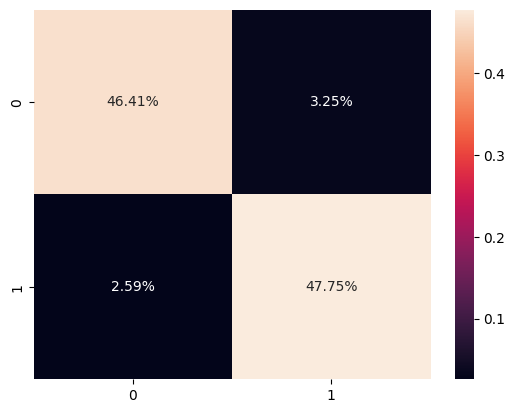

###################- End -###################


In [92]:
model_dl=model
pred = model_dl.predict(X_test)
acc = accuracy_score( np.round(pred), y_test)
print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
print('\033[01m              Classification_report \033[0m')
print(classification_report(y_test,  np.round(pred)))
print('\033[01m             Confusion_matrix \033[0m')
cf_matrix = confusion_matrix(y_test,  np.round(pred))
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()
print('\033[31m###################- End -###################\033[0m')

Le modèle de deep learning présente des performances solides avec des scores de précision, de rappel et de score F1 équilibrés pour les deux classes.
Bien que l'accuracy soit légèrement inférieure à celle des autres modèles évalués précédemment, 94.16 % reste un score respectable.

En modifiant quelques parametres tels que le nombre de couches, le nombre de neurones par couche, les fonctions d'activation, les techniques de régularisation et d'optimisation, il est possible d'obtenir des performances comparables voire supérieures à celles des modèles classiques comme XGBoost, Random Forest ou Bagging.

#Bref introduction au concept de topic modeling.

In [19]:
data.head()

,label,transformed_text
0,0,http sprint com business solution mobility sec...
1,0,hesperia gsfc nasa gov schmahl nnls
2,0,http web magazine digital sicher netz sicherhe...
3,0,www wire com science discovery news
4,1,thomas arnatt com include pono aol logio htm


Latent Dirichlet Allocation (LDA), est un algorithme de topic modeling qui est largement utilisé dans le domaine du traitement automatique du langage naturel et de l'apprentissage automatique. LDA est un modèle probabiliste génératif, ce qui signifie qu'il suppose qu'il existe des distributions de probabilité cachées qui génèrent les documents observés. Bien que l'algorithme soit complexe, il est largement utilisé pour découvrir les structures sous-jacentes des ensembles de documents et pour faciliter l'exploration et l'analyse de grands corpus textuels.

In [8]:
from gensim import corpora, models
# Tokenize and create a dictionary
tokenized_docs = [doc.lower().split() for doc in data.transformed_text]
dictionary = corpora.Dictionary(tokenized_docs)

# Convert tokenized documents to vectors
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Train LDA model
num_topics = 2
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

In [11]:
# Analyse des sujets
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)
for i, topic in topics:
    print(f"Topic {i}:")
    print([word for word, _ in topic])
    print()

Topic 0:
['com', 'http', 'net', 'login', 'html', 'paypal', 'org', 'torrent', 'php', 'tool']

Topic 1:
['com', 'www', 'html', 'htm', 'index', 'org', 'net', 'http', 'php', 'edu']



In [12]:
# Calculer la cohérence des sujets
coherence_model_lda = models.CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Coherence Score: 0.2962096869680876


Il est claire que le Topic 0 semble être associé à des URL utilisées dans des tentatives de phishing (presence de http,paypal,login), tandis que le Topic 1 semble être associé à des URL légitimes. Cependant, sans l'analyse faite avant, il serait difficile d'identifier ces deux classes uniquement à partir du résultat du topic modeling.

De plus, le score de cohérence du modèle LDA est de 0.29, ce qui indique une cohérence modérée des sujets extraits. Cela souligne l'importance d'associer les résultats du topic modeling à d'autres méthodes d'analyse et de prétraitement des données pour obtenir une interprétation précise et complète.

# Deuxième partie


Les changements dans les stratégies des fraudeurs rendent les modèles statiques inefficaces, En termes plus techniques, l’hypothèse selon laquelle “les données sont indépendantes et identiquement distribuées” devient fausse.
 Pour detecter le drift , il y a plusieurs methodes :

 - En se basant sur le label : Les mêmes kpi utilisés pour comparer les modèles peuvent être utilisés en définissant une marge de tolérance. Ensuite, une alerte sera déclenchée si la métrique surveillée atteint un seuil prédéterminé, et une alarme sera déclenchée si la métrique dépasse la marge.cela peut etre implemente en utilisant **Scikit Multiflow Library ** , il utilise les methodes suivantes ( DDM, EDDM, PageHinkley, ADWIN)

 - Univariate Drift detectors : en utilisant le test de Kolmogorov-Smirnov. Qui sert a  vérifier si les deux échantillons proviennent de la même distribution.
Cependant, un inconvénient majeur de cette methode est qu'elle est limitée aux dérives de concepts virtuels, un changement de distribution ne signifie pas toujours un changement dans la relation entre les covariables et la variable dépendante.cela peut etre implemente en utilisant **TensorFlow Data Validation** .

 - Multivariate Drift Detectors: c'une méthodologie particulièrement intéressante car elle suit les changements dans la distribution de densité attendue dans la marge. Par marge, la région d'incertitude d'un classifieur qui est proche de la frontière de classification. Tout changement significatif dans la distribution de densité de la marge devra être investigué. Elle est très puissantes, mais il est important de savoir qu'ils ne sont pas actuellement utilisés.

 Tout cloud a sa propre fonctionnalité pour la detection de la drift (Azure Machine Learning ,Amazon SageMaker Model Monitor...)

Methode pour incorporer des nouvelles informations au modeles:

 - Réajuster sur de nouvelles données en effectuant le fine-tuning du modèle. Cela implique de geler certaines parties du modèle et de ne mettre à jour que les couches finales ou spécifiques du modèle.

 - Apprentissage periodique du modèle: Ré-entraîner le modèle en incluant à la fois les données existantes et les nouvelles données. Cela nécessite généralement d'avoir accès à un ensemble de données étiqueté.



 Une fois que le modèle est en production, il peut arriver qu'on remarque tardivement une détérioration de ses performances, avec un temps considérable entre l'incident et la prise en charge de ce dernier , pour cela il est suggeré de :

 - la mise en place d'un systèmes automatisés qui surveillent en permanence les entrées, les sorties et les taux d'erreur du modèle. Celq permet de recueillir des données exploitables pour aborder un problème de timeseries. Cela ouvre la voie à la prédiction anticipée des moments où des problèmes avec le modèle pourraient survenir, permettant ainsi une maintenance prédictive.
 -
